# Lag, Scaling, Embedding(GMS), Diff then Shift y
## with Binary flags about Tax increase
## LSTM

In [21]:
### Set proxy environment variable to access outside
%env http_proxy=pkg.proxy.prod.jp.local:10080
%env https_proxy=pkg.proxy.prod.jp.local:10080
    
import getpass
import os

username, host = 'atsushi.kamitani', 'dm-red101.prod.jp.local'
password = getpass.getpass("Please input SPDB password: ")

os.environ["ODBCSYSINI"] = "/opt/teradata/client/ODBC_64"
os.environ["ODBCINI"] = "/opt/teradata/client/ODBC_64/odbc.ini"
os.environ["ODBCINST"] = "/opt/teradata/client/ODBC_64/odbcinst.ini"

env: http_proxy=pkg.proxy.prod.jp.local:10080
env: https_proxy=pkg.proxy.prod.jp.local:10080
Please input SPDB password: ········


In [22]:
# TERADATA EXTRACTION ICHIBA
import teradata
import pandas as pd

udaExec = teradata.UdaExec(appName="test", version="1.0", logConsole=True, logLevel="ERROR", odbcLibPath="/opt/teradata/client/ODBC_64/lib/libodbc.so")

query = '''(
select * from SBX_ICB_MKD.kam_GenreForecast where genre not in ('デジタルコンテンツ','サービス・リフォーム','不動産・住まい','光回線・モバイル通信')
)'''

with udaExec.connect(method="odbc",system=host, username=username, password=password,driver="Teradata Database ODBC Driver 16.20", authentication="LDAP", charset="UTF8") as connect:
    dfIchiba = pd.read_sql(query,connect)

dfIchiba['dt'] = pd.to_datetime(dfIchiba['dt'])
dfIchiba=dfIchiba.sort_values(by=['dt','genre'], ascending=True)

In [23]:
# GET FEATURES
from getCorona import dfCorona
from getStockpriceList import dfStockprice

df=pd.DataFrame()

df1=dfCorona().execute()
df2=dfStockprice().execute('stockJP.csv')
lstStocks=df2.columns.drop('dt')

df=pd.concat([df, dfIchiba], axis=1)
df=pd.merge(df, df1, how='left', on='dt')
df=pd.merge(df, df2, how='left', on='dt')

df=df.fillna(method='ffill')
for i in df1.columns[1:]:
    df.loc[:,[i]]=df.loc[:,[i]].fillna(method='bfill')
    
df=df.fillna(0)
# df=df.drop(columns=['cnt_order'])
df=df.drop(columns=['cnt_order','relieved','active','activesum'])
# df=df.drop(columns=['relieved','dead','activesum'])

In [24]:
def CreateDtFeatures(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.dt
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df= df.drop(columns=['date'])
    X = df[['quarter','month','year','weekofyear']]   #.set_index('dt')   # 'hour','dayofweek', 'dayofyear','dayofmonth',

    return df

In [25]:
def GenTax(df):  
    df['tax']=8
    mask = df.dt>='2019-10-01'
    df.loc[mask, 'tax'] = 10
    return df

def GenTaxFlag(df):  
    df['tax_flag']=0
    mask = df.dt=='2019-10-01'
    df.loc[mask, 'tax'] = 1
    return df

def GenPreTaxFlag(df):  
    df['tax_pre_flag']=0
    mask = df.dt=='2019-09-01'
    df.loc[mask, 'tax'] = 1
    return df

In [26]:
from sklearn.metrics import make_scorer
import numpy as np

# MAPE computation
def mape(y, yhat, perc=True):
    n = len(yhat.index) if type(yhat) == pd.Series else len(yhat)    
    mape = []
    for a, f in zip(y, yhat):
        # avoid division by 0
        if abs(a) > 1e-9:
            mape.append(np.abs((a - f)/a))
    mape = np.mean(np.array(mape))
    return mape * 100. if perc else mape

# mape_scorer = make_scorer(mape, greater_is_better=False)

In [27]:
from sklearn.decomposition import PCA

def PCAfeature(df, components, categ, lstColumn):
    dfTemp=df.loc[:,lstStock]
    
    pca = PCA(n_components=components)
    pca.fit(dfTemp)
    arPCAscore=pca.fit_transform(dfTemp)
    scorePCA=arPCAscore
    # scorePCA=scorePCA.reshape(-1,len(scorePCA))
    dfPCA=pd.DataFrame(scorePCA)
    
    colPCA=list()
    for f in range(0,components):
        colPCA.append(categ+str(f))
    dfPCA.columns=colPCA
    
    df=pd.concat([df,dfPCA], axis=1).drop(columns=lstColumn)
    return df

In [81]:
# BASE DATASET
df['dt_bgn'] = df['dt'].values.astype('datetime64[M]')

df_genre   =df.loc[:,['dt_bgn','genre']].groupby(['dt_bgn','genre']).max()
df_monthmax=df.loc[:,['dt_bgn','genre','dead_daily','cnt_uniq_ppl','cnt_uniq_user','cnt_uniq_shop','cnt_uniq_item']].groupby(['dt_bgn','genre']).max()
df_monthmax.columns=['dead_daily_max','cnt_uniq_ppl_max','cnt_uniq_user_max','cnt_uniq_shop_max','cnt_uniq_item_max']
clm_df_monthmax=df_monthmax.columns

df_monthmin=df.loc[:,['dt_bgn','genre','dead_daily','cnt_uniq_ppl','cnt_uniq_user','cnt_uniq_shop','cnt_uniq_item']].groupby(['dt_bgn','genre']).min()
df_monthmin.columns=['dead_daily_min','cnt_uniq_ppl_min','cnt_uniq_user_min','cnt_uniq_shop_min','cnt_uniq_item_min']
clm_df_monthmin=df_monthmin.columns

df_monthdif=pd.concat([df_monthmax, df_monthmin], axis=1)
clm_dif=['dead_daily_dif','cnt_uniq_ppl_dif','cnt_uniq_user_dif','cnt_uniq_shop_dif','cnt_uniq_item_dif']
for i in range(0,len(clm_dif)):
    df_monthdif[clm_dif[i]]=df_monthdif.loc[:,clm_df_monthmax[i]]-df_monthdif.loc[:,clm_df_monthmin[i]]

df_monthsum=df.loc[:,['dt_bgn','genre','gms','dead_daily','cnt_uniq_ppl','cnt_uniq_user','cnt_uniq_shop','cnt_uniq_item']].groupby(['dt_bgn','genre']).sum()
df_monthsum.columns=['gms','dead_daily_sum','cnt_uniq_ppl_sum','cnt_uniq_user_sum','cnt_uniq_shop_sum','cnt_uniq_item_sum']
df_monthavr=df.loc[:,['dt_bgn','genre','aov','dead_daily','cnt_uniq_ppl','cnt_uniq_user','cnt_uniq_shop','cnt_uniq_item']].groupby(['dt_bgn','genre']).mean()
df_monthavr.columns=['aov','dead_daily_av','cnt_uniq_ppl_av','cnt_uniq_user_av','cnt_uniq_shop_av','cnt_uniq_item_av']
    
lstStockMonth=list(['dt_bgn','genre'])
for i in lstStocks:
    lstStockMonth.append(i)

df_mthstock=df.loc[:,lstStockMonth].groupby(['dt_bgn','genre']).mean()
df_month=pd.concat([df_genre,df_monthsum,df_monthavr,df_monthdif,df_mthstock], axis=1)

df_month=df_month.reset_index()
df_month=df_month.rename(columns={'dt_bgn': 'dt'})
df_month.dt = df_month['dt'].values.astype('datetime64[M]')

df_month=GenTax(df_month)
# df_month=GenTaxFlag(df_month)
# df_month=GenPreTaxFlag(df_month)

df_month=CreateDtFeatures(df_month)


## Dimension Reduction: stock

In [82]:
comp=4
categ='stock'
lstStock=df_mthstock.columns

df_month=PCAfeature(df_month,comp,categ,lstStock)
len(df_month.columns)

38

## Dimension Reduction: SPDB

In [83]:
comp=6
categ='spdb'
lstStock=['cnt_uniq_ppl_max','cnt_uniq_user_max','cnt_uniq_shop_max','cnt_uniq_item_max',
          'cnt_uniq_ppl_min','cnt_uniq_user_min','cnt_uniq_shop_min','cnt_uniq_item_min',
          'cnt_uniq_ppl_av','cnt_uniq_user_av','cnt_uniq_shop_av','cnt_uniq_item_av']

df_month=PCAfeature(df_month,comp,categ,lstStock)
len(df_month.columns)

32

In [64]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.layers import Embedding, Dense, Flatten
import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sklearn

def embed_features(dfEmbed, dfOutput, param, input_dim, embedding_size=3):
    model = models.Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=embedding_size, input_length = 1, name="embedding"))
    model.add(Flatten())
    model.add(Dense(50, activation="relu"))
    model.add(Dense(15, activation="relu"))
    model.add(Dense(1))
    model.compile(loss = "mse", optimizer = "adam", metrics=["accuracy"])
    model.fit(x = dfEmbed[param+'_embd'], y=dfEmbed['gms_scaled'] , epochs = 50, batch_size = 4, verbose=0)
    
    layer = model.get_layer('embedding')
    output_embeddings = layer.get_weights()
    
    output_embeddings_df = pd.DataFrame(output_embeddings[0]);output_embeddings_df
    output_embeddings_df = pd.concat([dfOutput.iloc[:,0], output_embeddings_df], axis=1)
    
    clmDF=list()
    clmDF.append(output_embeddings_df.columns[0])
    for i in output_embeddings_df.columns[1:]:
        clmDF.append(str(str(output_embeddings_df.columns[0])+str(i)))
    output_embeddings_df.columns=clmDF

    #clmKeep=list(['index'])
    #for i in clmDF[1:]:
    #    clmKeep.append(i)
    
    dfEmbed=pd.merge(dfEmbed, output_embeddings_df, on=param+'_embd')
    dfEmbed=dfEmbed.sort_values('index').reset_index(drop=True).loc[:,clmDF[1:]]
    
    return dfEmbed

## TEST DATESET

In [31]:
from matplotlib import pyplot
import numpy as np
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, cross_val_score)
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pylab as plt
from IPython.core.display import display, HTML

from LogDifferentialBack import LogDifferential as ld
from TargetTransformer   import TargetTransformer
from LagFeatureCreate2   import dfTransform


i='CD・DVD'
dfGenre=df_month[df_month.genre==i].reset_index(drop=True)
dfGenre=dfGenre.sort_values(by='dt', ascending=True)

p=1
dfLag  =dfTransform.create_lag_features(dfGenre.gms, p, 12)   # the lag is adjusted toward the forecasting step: p --lag0 here =lag1
dfData =pd.concat([dfGenre, dfLag],axis=1).drop(columns=['dt','genre']).diff().dropna().reset_index(drop=True)

lstEmbed = list(['gms','quarter', 'month', 'year'])

# EMBEDDING TIME FEATURES
print('feature embedding ...')
dfEmbedBase=dfData.loc[:,lstEmbed]
embd_scaler = MinMaxScaler(feature_range=(0, 1))
embd_scaler.fit(dfGenre.gms.values.reshape(-1, 1))
dfEmbedBase['gms_scaled']=embd_scaler.transform(dfData.gms.values.reshape(-1, 1))
dfEmbedBase.columns[1:]

dfEmbedAll=pd.DataFrame()
for q in dfEmbedBase.columns[1:-1]:
    dfEmbed=dfEmbedBase.loc[:,['gms_scaled',q]]
    dfOutput=pd.DataFrame(dfEmbed[q].sort_values().unique()).reset_index()
    dfOutput.columns=[str(q)+'_embd',q]
    dfEmbed=pd.merge(dfEmbed, dfOutput, on=q)
    dfEmbed=dfEmbed.reset_index()                        # .sort_values(dfEmbed.columns[-1])
    input_dim=len(dfEmbed.loc[:,q].unique())       
    dfFeatureEmbeded=embed_features(dfEmbed, dfOutput, q, input_dim) #, embedding_size
    dfEmbedAll=pd.concat([dfEmbedAll, dfFeatureEmbeded], axis=1)
    # EMBEDDED DATA HAS TO BE MERGED AFTER SCALING OTHERWISE BECOME INTEGER

print('feature embedding done')
dfData =pd.concat([dfData, dfEmbedAll],axis=1)

y_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler.fit(dfData.gms.values.reshape(-1, 1))
npar1=y_scaler.transform(dfData.gms.values.reshape(-1, 1))
x_scaler = MinMaxScaler(feature_range=(0, 1))
x_scaler.fit(dfData.iloc[:,1:])
npar2=x_scaler.transform(dfData.iloc[:,1:].values)

[1, 4, 3, 11]
[0, 3, 2, 10]
feature embedding ...
feature embedding done


# LSTM

In [60]:
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    return y

In [62]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

look_back = 12
test_size=2
steps=2

X_train, X_test, y_train, y_test = train_test_split(npar2, npar1, test_size=look_back+test_size, shuffle=False) 

train_data_gen = TimeseriesGenerator(X_train, y_train,length=look_back, sampling_rate=1,stride=1,batch_size=1)  # steps
test_data_gen  = TimeseriesGenerator(X_test,  y_test, length=look_back, sampling_rate=1,stride=1,batch_size=1)  # steps

shapeX=X_train.shape[1]

model = Sequential()
model.add(LSTM(1, input_shape=(look_back, shapeX)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history = model.fit(train_data_gen, epochs=100, verbose=0).history
# print(model.evaluate_generator(test_data_gen))

train_y = get_y_from_generator(train_data_gen)
train_y = y_scaler.inverse_transform(train_y)
train_yhat = model.predict_generator(train_data_gen)
train_yhat = y_scaler.inverse_transform(train_yhat)

test_y  = get_y_from_generator(test_data_gen)
test_y  = y_scaler.inverse_transform(test_y)
test_yhat = model.predict_generator(test_data_gen)
test_yhat = y_scaler.inverse_transform(test_yhat)

dfStart  =dfGenre.gms.iloc[-len(test_y)-1]
actual   =np.append(dfStart,test_y   ).cumsum()[1:]
predicted=np.append(dfStart,test_yhat).cumsum()[1:]

[1, 4, 3, 11]
[0, 3, 2, 10]
feature embedding ...
................... done
CD・DVD,step:1,prediction period:14
LSTM running ...
................... done


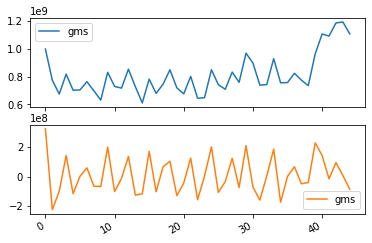

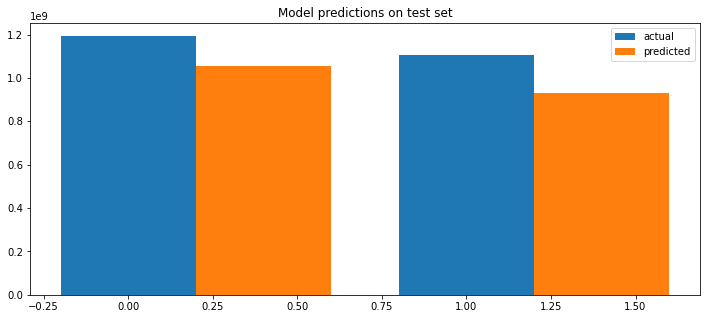

CD・DVD,step:1,prediction period:14
percentage difference: 0.1172 / 0.1595
score - mape: 13.8360

[1, 3, 10, 2]
[0, 2, 9, 1]
feature embedding ...
................... done
TV・オーディオ・カメラ,step:1,prediction period:14
LSTM running ...
................... done


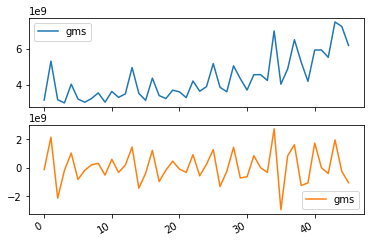

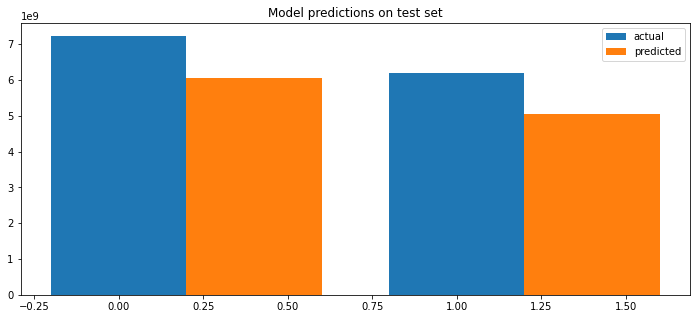

TV・オーディオ・カメラ,step:1,prediction period:14
percentage difference: 0.1635 / 0.1843
score - mape: 17.3871

[12, 1]
[11, 0]
feature embedding ...
................... done
おもちゃ,step:1,prediction period:14
LSTM running ...
................... done


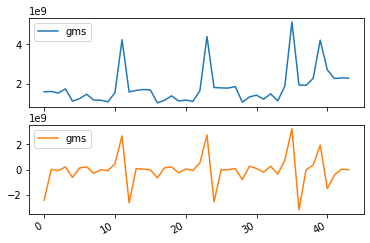

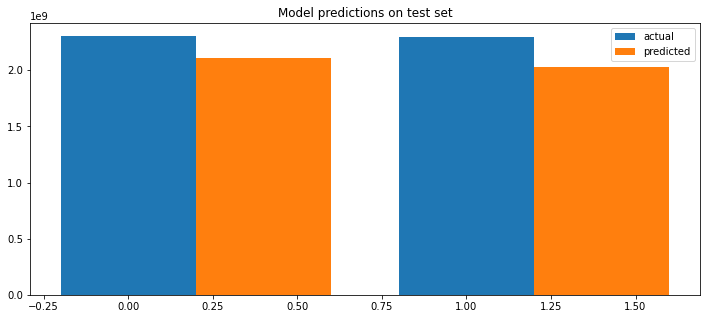

おもちゃ,step:1,prediction period:14
percentage difference: 0.0846 / 0.1167
score - mape: 10.0649

[1, 4, 6, 3]
[0, 3, 5, 2]
feature embedding ...
................... done
インテリア・寝具・収納,step:1,prediction period:14
LSTM running ...
................... done


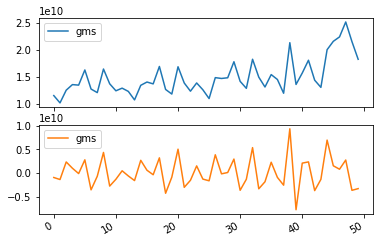

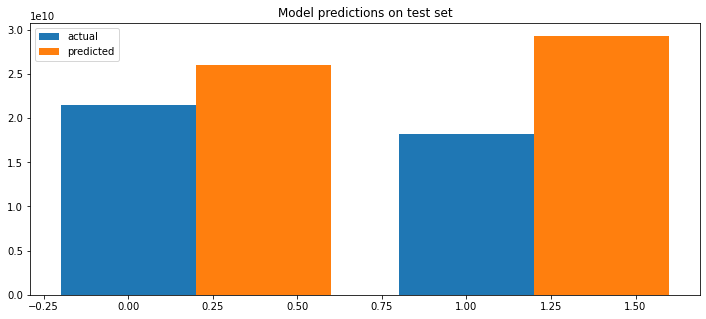

インテリア・寝具・収納,step:1,prediction period:14
percentage difference: 0.2128 / 0.6092
score - mape: 41.0991

[6, 1, 7, 5, 4, 9, 3]
[5, 0, 6, 4, 3, 8, 2]
feature embedding ...
................... done
インナー・下着・ナイトウェア,step:1,prediction period:14
LSTM running ...
................... done


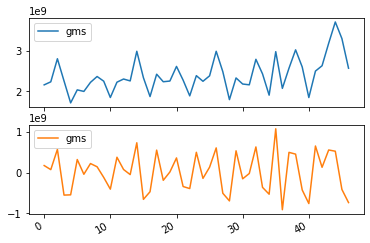

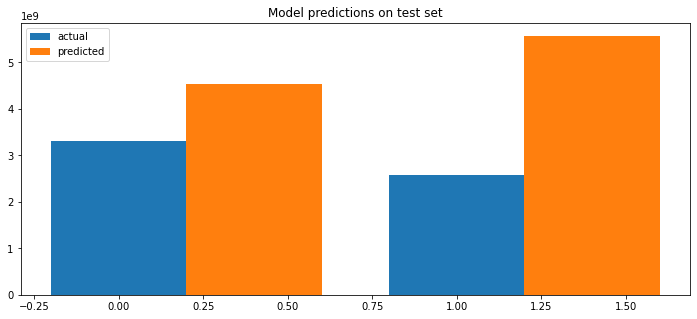

インナー・下着・ナイトウェア,step:1,prediction period:14
percentage difference: 0.3710 / 1.1629
score - mape: 76.6955

[1, 12, 3]
[0, 11, 2]
feature embedding ...
................... done
カタログギフト・チケット,step:1,prediction period:14
LSTM running ...
................... done


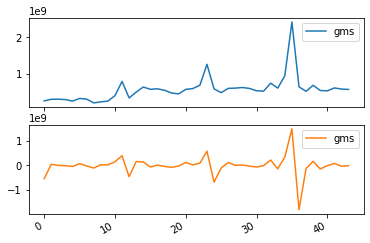

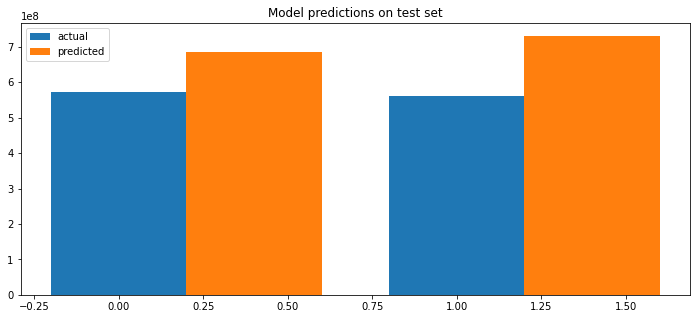

カタログギフト・チケット,step:1,prediction period:14
percentage difference: 0.1960 / 0.3014
score - mape: 24.8691

[12, 3, 6, 4, 7, 5]
[11, 2, 5, 3, 6, 4]
feature embedding ...
................... done
キッズ・ベビー・マタニティ,step:1,prediction period:14
LSTM running ...
................... done


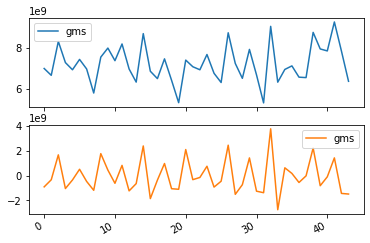

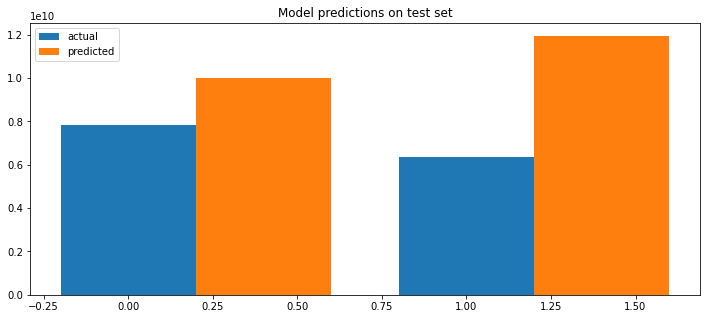

キッズ・ベビー・マタニティ,step:1,prediction period:14
percentage difference: 0.2755 / 0.8776
score - mape: 57.6538

[1, 4, 3, 11, 6]
[0, 3, 2, 10, 5]
feature embedding ...
................... done
キッチン用品・食器・調理器具,step:1,prediction period:14
LSTM running ...
................... done


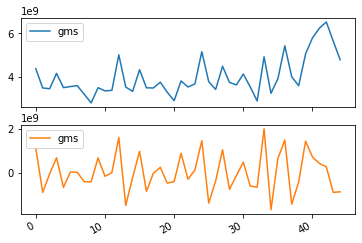

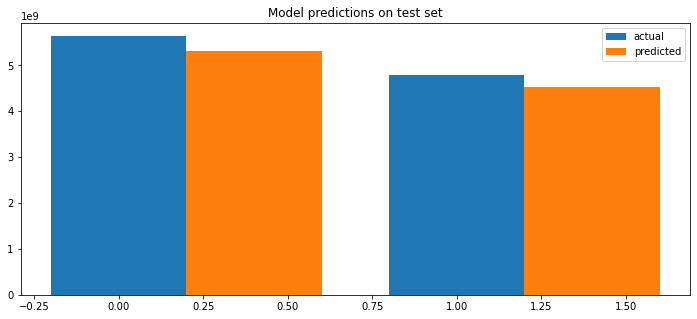

キッチン用品・食器・調理器具,step:1,prediction period:14
percentage difference: 0.0584 / 0.0525
score - mape: 5.5416

[12, 3, 4, 9, 10, 2, 11]
[11, 2, 3, 8, 9, 1, 10]
feature embedding ...
................... done
ジュエリー・アクセサリー,step:1,prediction period:14
LSTM running ...
................... done


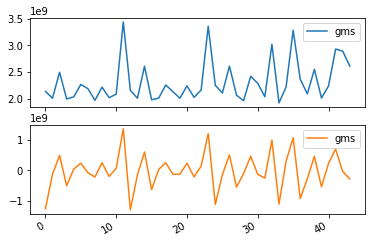

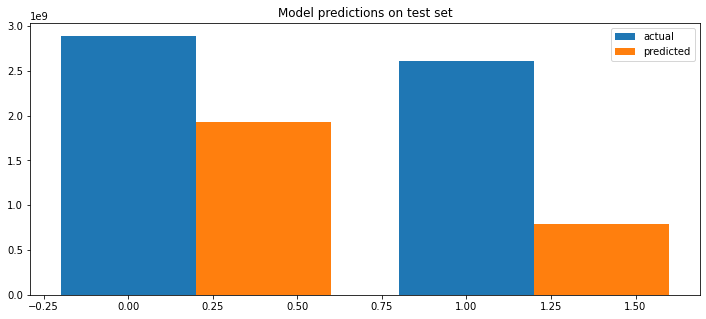

ジュエリー・アクセサリー,step:1,prediction period:14
percentage difference: 0.3320 / 0.6985
score - mape: 51.5233

[9, 1, 11, 8, 4]
[8, 0, 10, 7, 3]
feature embedding ...
................... done
スイーツ・お菓子,step:1,prediction period:14
LSTM running ...
................... done


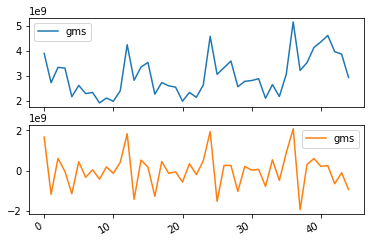

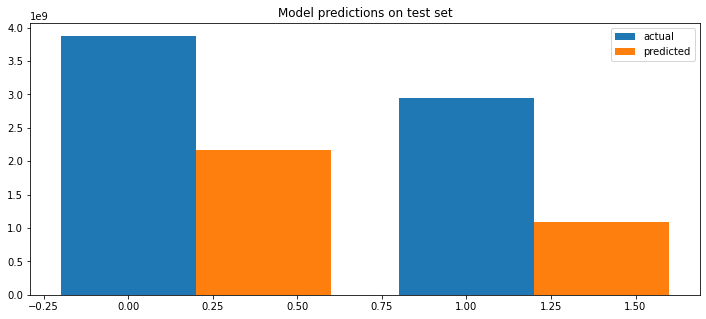

スイーツ・お菓子,step:1,prediction period:14
percentage difference: 0.4411 / 0.6288
score - mape: 53.4922

[1, 6, 4, 11, 3, 9]
[0, 5, 3, 10, 2, 8]
feature embedding ...
................... done
スポーツ・アウトドア,step:1,prediction period:14
LSTM running ...
................... done


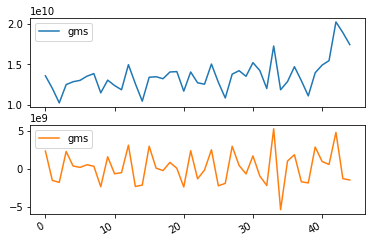

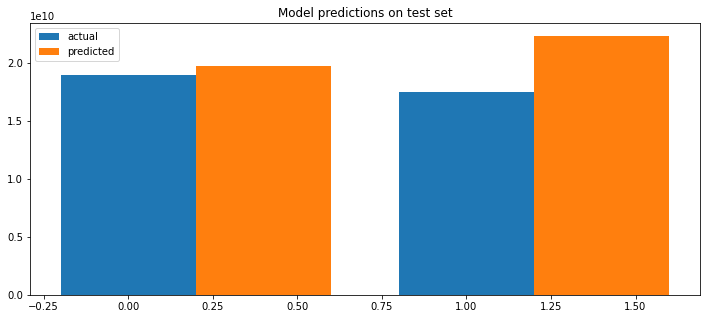

スポーツ・アウトドア,step:1,prediction period:14
percentage difference: 0.0412 / 0.2782
score - mape: 15.9669

[1, 4, 3, 10, 6]
[0, 3, 2, 9, 5]
feature embedding ...
................... done
スマートフォン・タブレット,step:1,prediction period:14
LSTM running ...
................... done


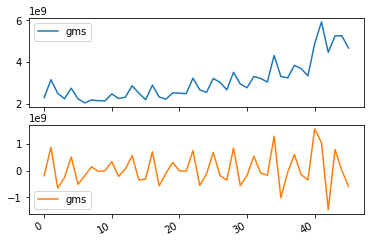

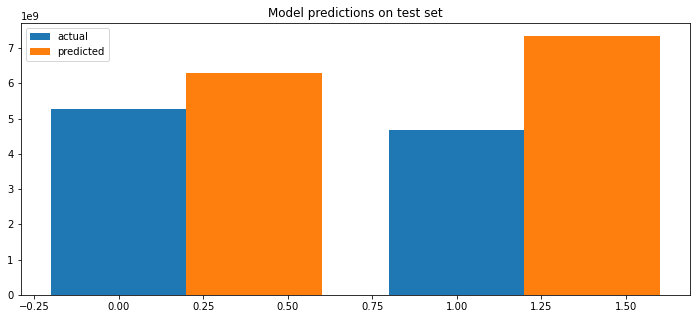

スマートフォン・タブレット,step:1,prediction period:14
percentage difference: 0.1955 / 0.5730
score - mape: 38.4267

[1, 6, 3, 4, 5, 2]
[0, 5, 2, 3, 4, 1]
feature embedding ...
................... done
ダイエット・健康,step:1,prediction period:14
LSTM running ...
................... done


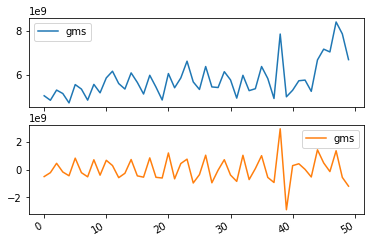

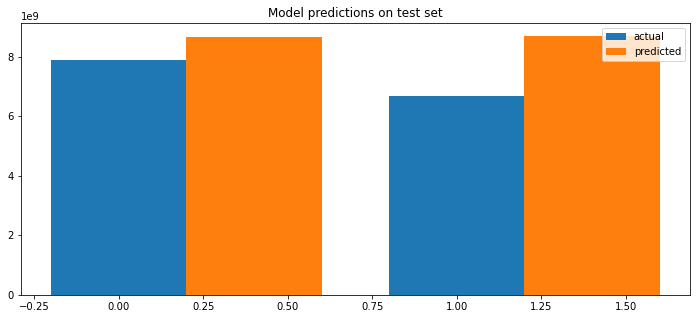

ダイエット・健康,step:1,prediction period:14
percentage difference: 0.0981 / 0.2989
score - mape: 19.8504

[3, 12, 4, 2, 10, 9, 11]
[2, 11, 3, 1, 9, 8, 10]
feature embedding ...
................... done
バッグ・小物・ブランド雑貨,step:1,prediction period:14
LSTM running ...
................... done


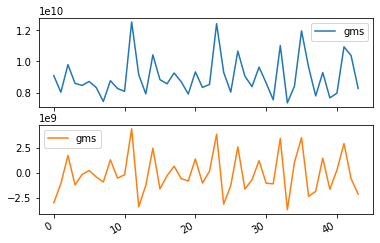

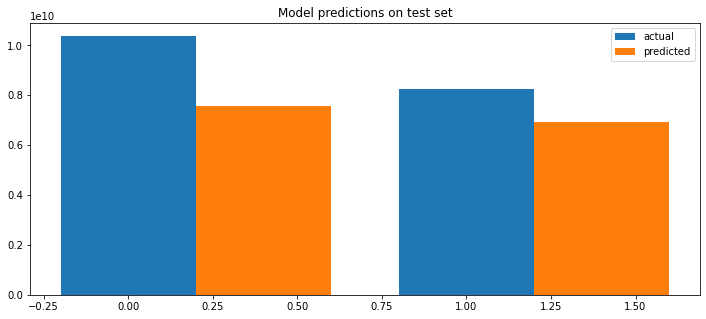

バッグ・小物・ブランド雑貨,step:1,prediction period:14
percentage difference: 0.2718 / 0.1623
score - mape: 21.7018

[1, 3, 10, 2, 4, 5]
[0, 2, 9, 1, 3, 4]
feature embedding ...
................... done
パソコン・周辺機器,step:1,prediction period:14
LSTM running ...
................... done


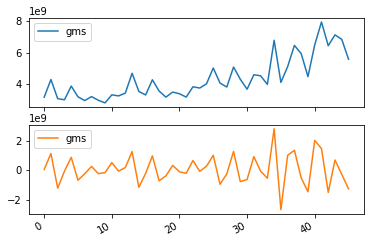

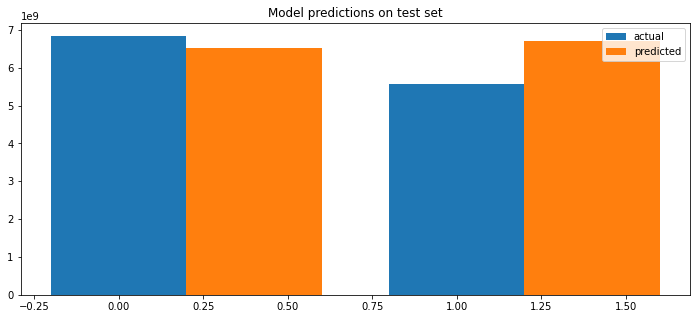

パソコン・周辺機器,step:1,prediction period:14
percentage difference: 0.0475 / 0.2032
score - mape: 12.5371

[12, 6, 1, 3, 5]
[11, 5, 0, 2, 4]
feature embedding ...
................... done
ビール・洋酒,step:1,prediction period:14
LSTM running ...
................... done


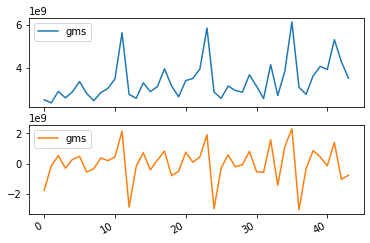

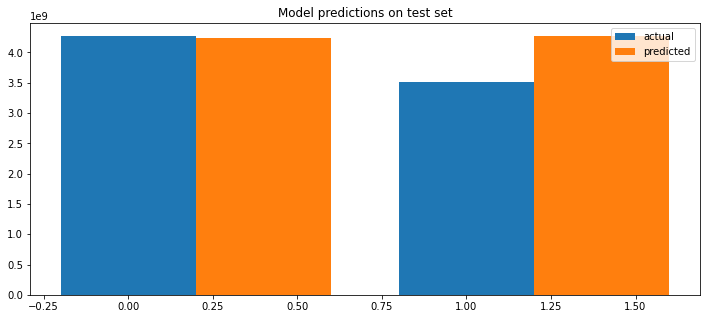

ビール・洋酒,step:1,prediction period:14
percentage difference: 0.0062 / 0.2155
score - mape: 11.0852

[1, 3, 2]
[0, 2, 1]
feature embedding ...
................... done
ペット・ペットグッズ,step:1,prediction period:14
LSTM running ...
................... done


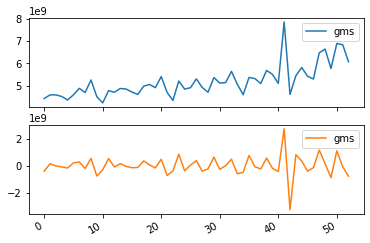

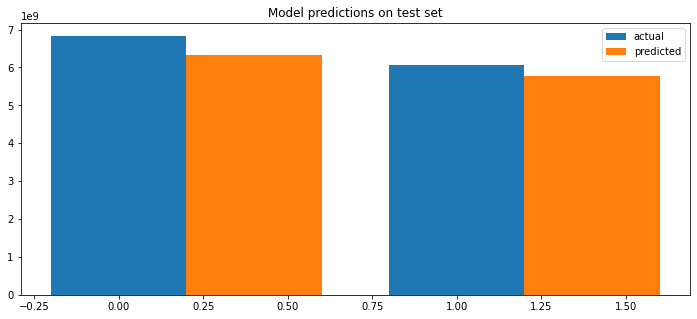

ペット・ペットグッズ,step:1,prediction period:14
percentage difference: 0.0748 / 0.0495
score - mape: 6.2130

[1, 12, 4, 9, 8]
[0, 11, 3, 8, 7]
feature embedding ...
................... done
ホビー,step:1,prediction period:14
LSTM running ...
................... done


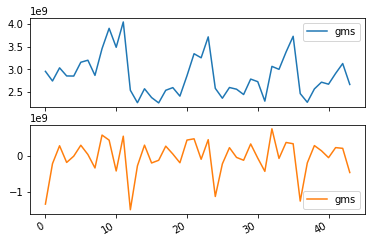

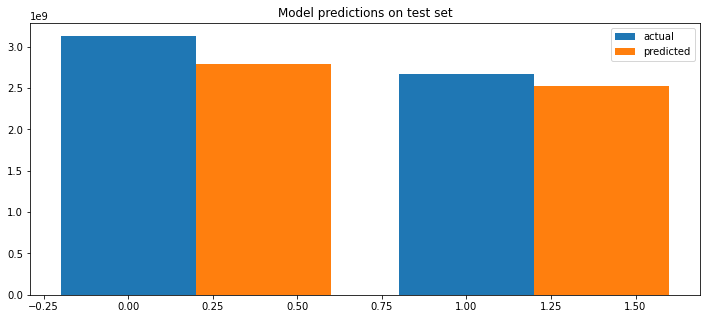

ホビー,step:1,prediction period:14
percentage difference: 0.1080 / 0.0516
score - mape: 7.9777

[11, 1, 2, 5, 4, 7, 8]
[10, 0, 1, 4, 3, 6, 7]
feature embedding ...
................... done
メンズファッション,step:1,prediction period:14
LSTM running ...
................... done


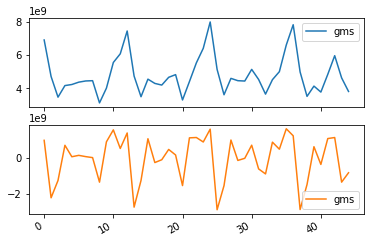

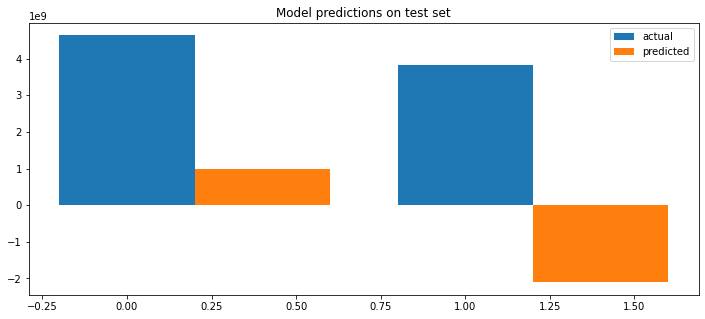

メンズファッション,step:1,prediction period:14
percentage difference: 0.7857 / 1.5530
score - mape: 116.9377

[12, 7, 11, 6, 4]
[11, 6, 10, 5, 3]
feature embedding ...
................... done
レディースファッション,step:1,prediction period:14
LSTM running ...
................... done


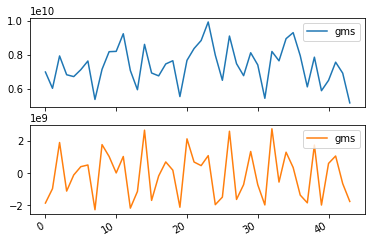

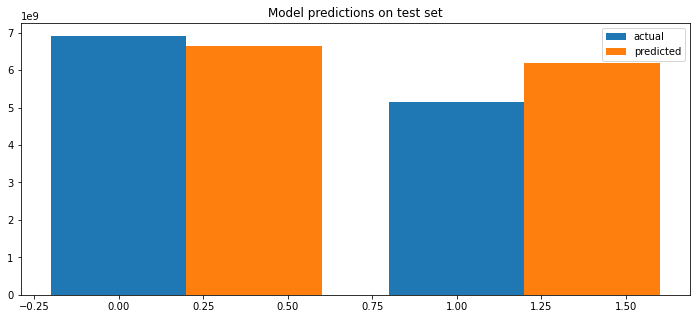

レディースファッション,step:1,prediction period:14
percentage difference: 0.0392 / 0.2002
score - mape: 11.9712

[1]
[0]
feature embedding ...
................... done
医薬品・コンタクト・介護,step:1,prediction period:14
LSTM running ...
................... done


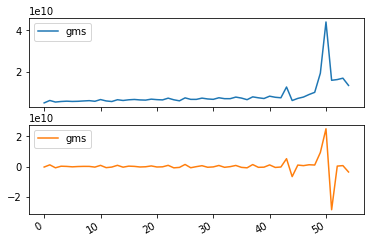

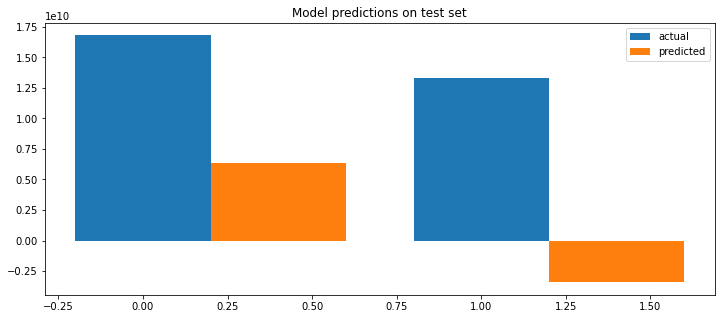

医薬品・コンタクト・介護,step:1,prediction period:14
percentage difference: 0.6230 / 1.2587
score - mape: 94.0850

[1, 6, 11]
[0, 5, 10]
feature embedding ...
................... done
家電,step:1,prediction period:14
LSTM running ...
................... done


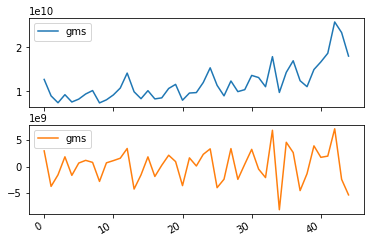

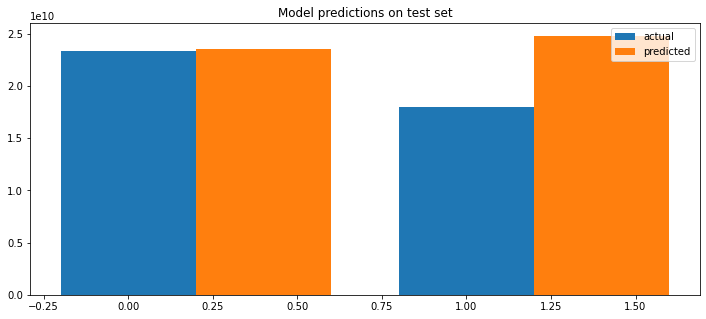

家電,step:1,prediction period:14
percentage difference: 0.0057 / 0.3751
score - mape: 19.0383

[6, 4, 12, 2, 7]
[5, 3, 11, 1, 6]
feature embedding ...
................... done
日本酒・焼酎,step:1,prediction period:14
LSTM running ...
................... done


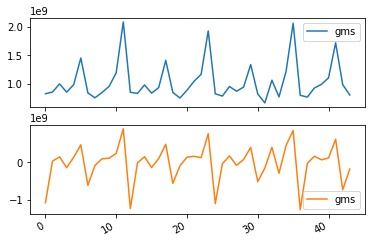

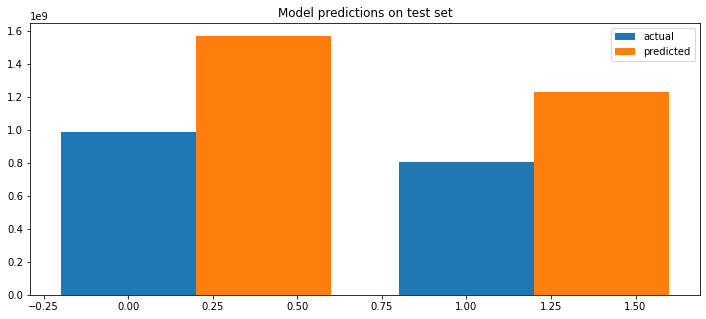

日本酒・焼酎,step:1,prediction period:14
percentage difference: 0.5882 / 0.5253
score - mape: 55.6751

[1, 4]
[0, 3]
feature embedding ...
................... done
日用品雑貨・文房具・手芸,step:1,prediction period:14
LSTM running ...
................... done


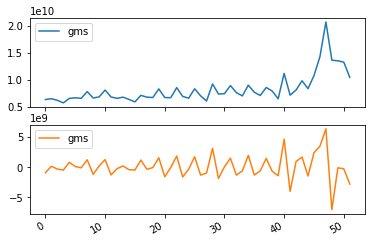

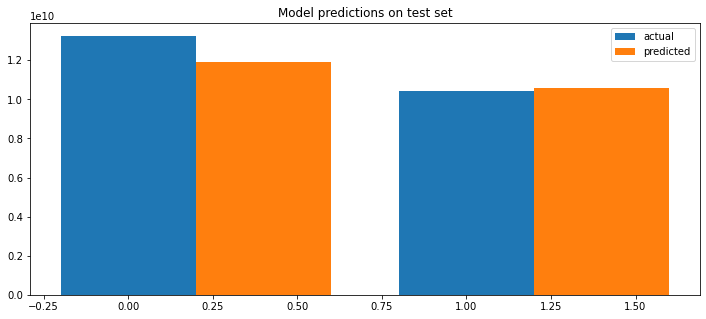

日用品雑貨・文房具・手芸,step:1,prediction period:14
percentage difference: 0.0996 / 0.0149
score - mape: 5.7257

[1, 3, 2]
[0, 2, 1]
feature embedding ...
................... done
本・雑誌・コミック,step:1,prediction period:14
LSTM running ...
................... done


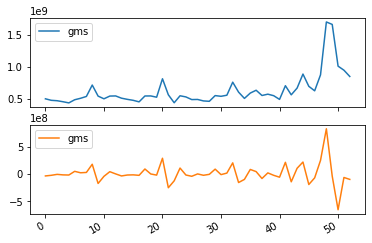

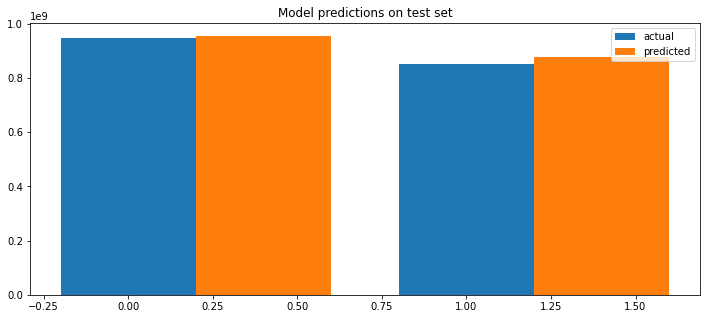

本・雑誌・コミック,step:1,prediction period:14
percentage difference: 0.0078 / 0.0325
score - mape: 2.0130

[1, 4, 11, 3, 9, 6]
[0, 3, 10, 2, 8, 5]
feature embedding ...
................... done
水・ソフトドリンク,step:1,prediction period:14
LSTM running ...
................... done


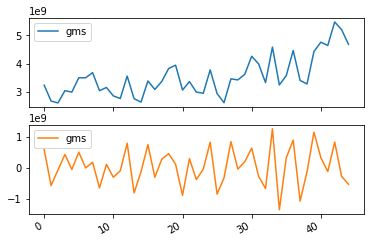

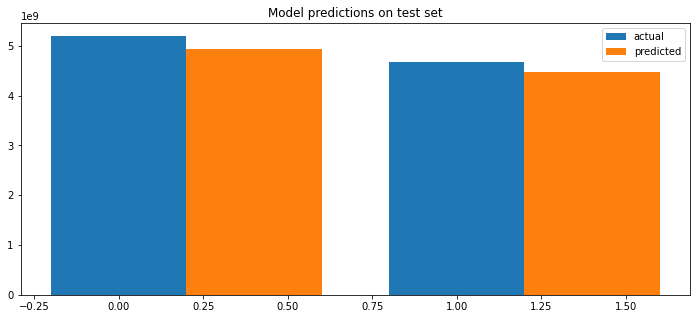

水・ソフトドリンク,step:1,prediction period:14
percentage difference: 0.0486 / 0.0452
score - mape: 4.6910

[1, 3, 2, 6, 5, 4]
[0, 2, 1, 5, 4, 3]
feature embedding ...
................... done
美容・コスメ・香水,step:1,prediction period:14
LSTM running ...
................... done


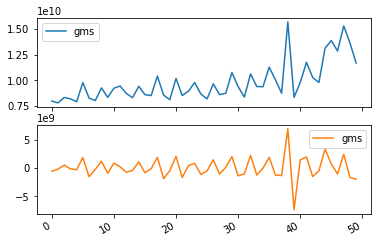

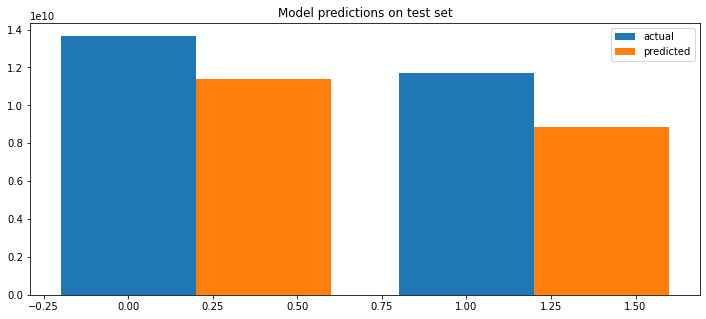

美容・コスメ・香水,step:1,prediction period:14
percentage difference: 0.1675 / 0.2449
score - mape: 20.6201

[3, 12, 6, 10, 9, 4, 11]
[2, 11, 5, 9, 8, 3, 10]
feature embedding ...
................... done
腕時計,step:1,prediction period:14
LSTM running ...
................... done


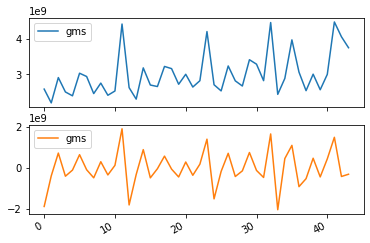

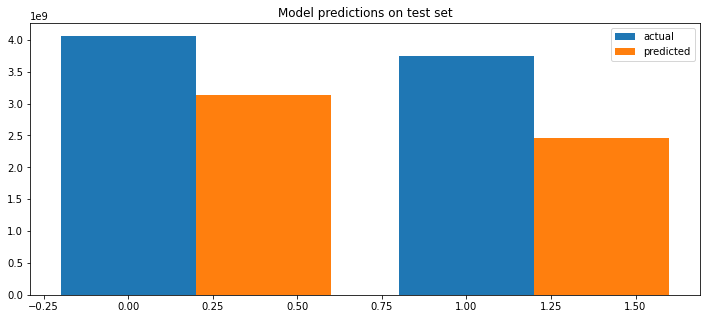

腕時計,step:1,prediction period:14
percentage difference: 0.2299 / 0.3445
score - mape: 28.7227

[1, 2, 9]
[0, 1, 8]
feature embedding ...
................... done
花・ガーデン・DIY,step:1,prediction period:14
LSTM running ...
................... done


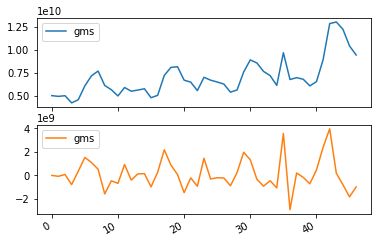

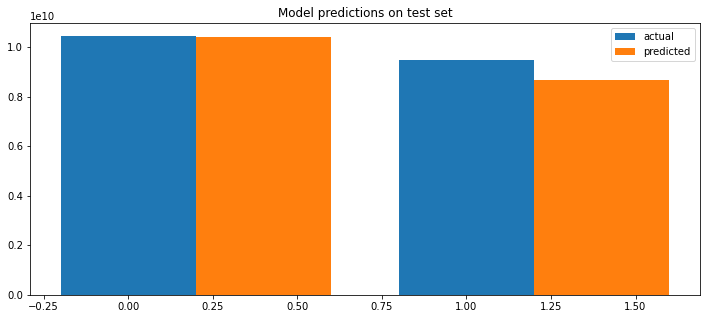

花・ガーデン・DIY,step:1,prediction period:14
percentage difference: 0.0035 / 0.0858
score - mape: 4.4649

[3, 5, 12]
[2, 4, 11]
feature embedding ...
................... done
車・バイク,step:1,prediction period:14
LSTM running ...
................... done


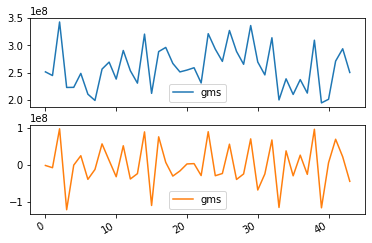

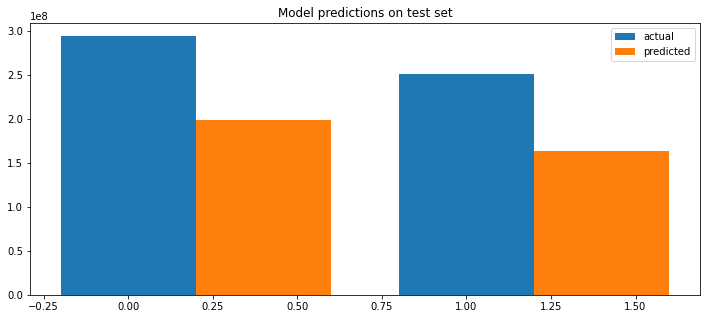

車・バイク,step:1,prediction period:14
percentage difference: 0.3232 / 0.3487
score - mape: 33.5955

[1, 11, 3, 10]
[0, 10, 2, 9]
feature embedding ...
................... done
車用品・バイク用品,step:1,prediction period:14
LSTM running ...
................... done


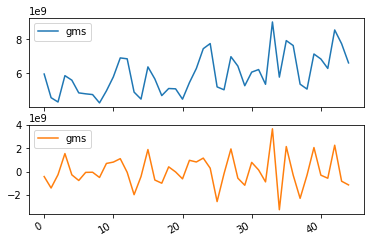

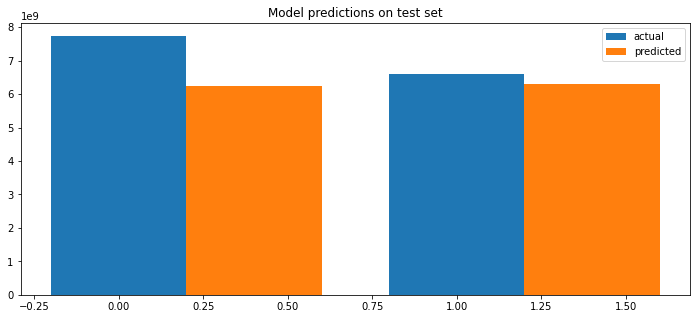

車用品・バイク用品,step:1,prediction period:14
percentage difference: 0.1941 / 0.0448
score - mape: 11.9450

[4, 2, 6, 10, 5]
[3, 1, 5, 9, 4]
feature embedding ...
................... done
靴,step:1,prediction period:14
LSTM running ...
................... done


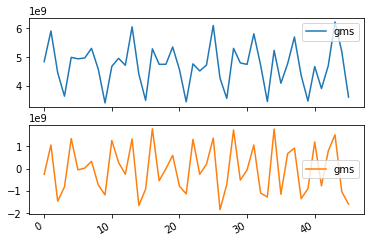

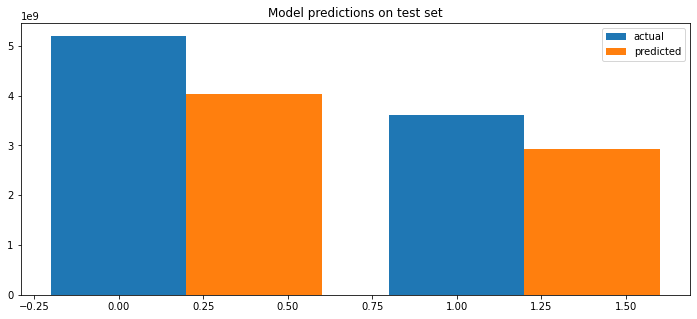

靴,step:1,prediction period:14
percentage difference: 0.2260 / 0.1894
score - mape: 20.7698

[12, 1]
[11, 0]
feature embedding ...
................... done
食品,step:1,prediction period:14
LSTM running ...
................... done


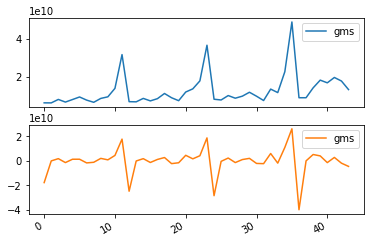

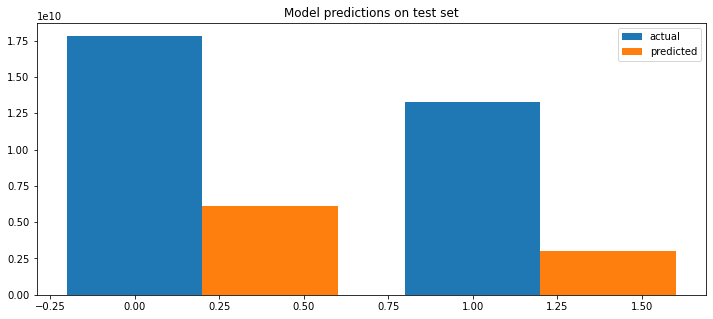

食品,step:1,prediction period:14
percentage difference: 0.6561 / 0.7736
score - mape: 71.4838



0

In [84]:
from matplotlib import pyplot
%matplotlib inline 

import numpy as np
from sklearn.model_selection import (TimeSeriesSplit, train_test_split, cross_val_score)
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pylab as plt
from IPython.core.display import display, HTML

from LogDifferentialBack import LogDifferential as ld
from TargetTransformer   import TargetTransformer
from LagFeatureCreate2   import dfTransform

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import mean_squared_error

# lstGenre=pd.unique(dfTrain.genre);lstGenre
dfGenre=pd.DataFrame()
dfResults=['genre,step,period,mape,diff1,diff2']
lstGenre=pd.unique(df_month.genre)
lstSteps=[1]  # [1,2,3]
test_size=2

look_back = 12


for i in lstGenre:
    dfGenre=df_month[df_month.genre==i].reset_index(drop=True)
    dfGenre=dfGenre.sort_values(by='dt', ascending=True)
    for p in lstSteps:        
        # CREATE STEPPED DATA
        dfLag  =dfTransform.create_lag_features(dfGenre.gms, p, 12)   # the lag is adjusted toward the forecasting step: p --lag0 here =lag1
        dfData =pd.concat([dfGenre, dfLag],axis=1).drop(columns=['dt','genre']).diff().dropna().reset_index(drop=True)

        # 1: Log Transform & Differential of Target & Features
        # 2: Create Lagged Targets as Features ---- the number of lagged features will be different among genre
        # lstEmbed = list([dfLag.columns[0],'quarter', 'month', 'year'])
        lstEmbed = list(['gms','quarter', 'month', 'year'])

        # EMBEDDING TIME FEATURES
        print('feature embedding ...')
        dfEmbedBase=dfData.loc[:,lstEmbed]
        embd_scaler = MinMaxScaler(feature_range=(0, 1))
        embd_scaler.fit(dfGenre.gms.values.reshape(-1, 1))
        dfEmbedBase['gms_scaled']=embd_scaler.transform(dfData.gms.values.reshape(-1, 1))
        dfEmbedBase.columns[1:]

        dfEmbedAll=pd.DataFrame()
        for q in dfEmbedBase.columns[1:-1]:
            dfEmbed=dfEmbedBase.loc[:,['gms_scaled',q]]
            dfOutput=pd.DataFrame(dfEmbed[q].sort_values().unique()).reset_index()
            dfOutput.columns=[str(q)+'_embd',q]
            dfEmbed=pd.merge(dfEmbed, dfOutput, on=q)
            dfEmbed=dfEmbed.reset_index()                        # .sort_values(dfEmbed.columns[-1])
            input_dim=len(dfEmbed.loc[:,q].unique())       
            dfFeatureEmbeded=embed_features(dfEmbed, dfOutput, q, input_dim) #, embedding_size
            dfEmbedAll=pd.concat([dfEmbedAll, dfFeatureEmbeded], axis=1)
            # EMBEDDED DATA HAS TO BE MERGED AFTER SCALING OTHERWISE BECOME INTEGER
        print('................... done')

        dfData =pd.concat([dfData, dfEmbedAll],axis=1)

        y_scaler = MinMaxScaler(feature_range=(0, 1))
        y_scaler.fit(dfData.gms.values.reshape(-1, 1))
        npar1=y_scaler.transform(dfData.gms.values.reshape(-1, 1))
        x_scaler = MinMaxScaler(feature_range=(0, 1))
        x_scaler.fit(dfData.iloc[:,1:])
        npar2=x_scaler.transform(dfData.iloc[:,1:].values)
                
        X_train, X_test, y_train, y_test = train_test_split(npar2, npar1, test_size=look_back+test_size, shuffle=False) 
        strStep=str(i)+',step:'+str(p)+',prediction period:'+str(len(y_test))
        print(strStep)

        train_data_gen = TimeseriesGenerator(X_train, y_train,length=look_back, sampling_rate=1,stride=p,batch_size=1)  # steps
        test_data_gen  = TimeseriesGenerator(X_test,  y_test, length=look_back, sampling_rate=1,stride=p,batch_size=1)  # steps

        shapeX=X_train.shape[1]

        print('LSTM running ...')
        model = Sequential()
        model.add(LSTM(1, input_shape=(look_back, shapeX)))
        model.add(Dense(50))
        model.add(Dense(1))
        model.compile(loss='mean_squared_error', optimizer='adam')
        history = model.fit(train_data_gen, epochs=100, verbose=0).history
        # print(model.evaluate_generator(test_data_gen))
        print('................... done')

        train_y = get_y_from_generator(train_data_gen)
        train_y = y_scaler.inverse_transform(train_y)
        train_yhat = model.predict_generator(train_data_gen)
        train_yhat = y_scaler.inverse_transform(train_yhat)

        test_y  = get_y_from_generator(test_data_gen)
        test_y  = y_scaler.inverse_transform(test_y)
        test_yhat = model.predict_generator(test_data_gen)
        test_yhat = y_scaler.inverse_transform(test_yhat)

        dfStart  =dfGenre.gms.iloc[-len(test_y)-1]
        actual   =np.append(dfStart,test_y   ).cumsum()[1:]
        predicted=np.append(dfStart,test_yhat).cumsum()[1:]
        position=np.arange(len(predicted))

        test_score = mape(actual, predicted)

        # plot predictions on the test set
        axes = pd.concat([dfGenre.gms.iloc[-dfData.shape[0]:].reset_index(drop=True),dfData.gms], axis=1).plot.line(subplots=True)
        type(axes)
                
        fig, (ax2) = plt.subplots(1, 1, figsize=(12, 5))
        ax2.bar(position, actual.astype(np.float64), label="actual", width=0.4)
        ax2.bar(position + 0.4, predicted.astype(np.float64), label="predicted", width=0.4)
        ax2.set_title("Model predictions on test set")
        ax2.legend()
        plt.show()
        
        
        dif0=abs(actual[0].astype(np.float64)-predicted[0].astype(np.float64))/actual[0].astype(np.float64)
        dif1=abs(actual[1].astype(np.float64)-predicted[1].astype(np.float64))/actual[1].astype(np.float64)
        
        print(strStep)
        print(f"percentage difference: {dif0:.4f} / {dif1:.4f}")
        print(f"score - mape: {test_score:.4f}")
        print()
        
        # store the results
        dfResults.append(strStep+','+str('{:.4f}'.format(test_score))+','+str(dif0)+','+str(dif1))
        
import datetime
filResult='result_{}.csv'.format(datetime.datetime.now().strftime('%Y-%m-%d_%H%M%S'))
pd.DataFrame(dfResults).to_csv(filResult, index=False, header=False)

import subprocess
subprocess.call(["""sed -i -e 's/"//g' {}""".format(filResult)], shell=True)

In [86]:
allresults=pd.read_csv(filResult)
print(filResult)
print('step1 average mape of all genre: ', allresults[allresults.step=='step:1'].mape.mean())
print('step2 average mape of all genre: ', allresults[allresults.step=='step:2'].mape.mean())

print('step1 min mape of all genre: ', allresults[allresults.step=='step:1'].mape.min())
print('step2 min mape of all genre: ', allresults[allresults.step=='step:2'].mape.min())

print('step1 max mape of all genre: ', allresults[allresults.step=='step:1'].mape.max())
print('step2 max mape of all genre: ', allresults[allresults.step=='step:2'].mape.max())

result_2020-09-17_175314.csv
step1 average mape of all genre:  29.929096969696978
step2 average mape of all genre:  nan
step1 min mape of all genre:  2.013
step2 min mape of all genre:  nan
step1 max mape of all genre:  116.9377
step2 max mape of all genre:  nan


In [90]:
test1=allresults[allresults.step=='step:1'].loc[:,['genre','diff1']]
test1.columns=['genre','diff']
test2=allresults[allresults.step=='step:1'].loc[:,['genre','diff2']]
test2.columns=['genre','diff']
test=pd.concat([test1,test2],axis=0)
test['diff'].mean()

0.2992910008235463

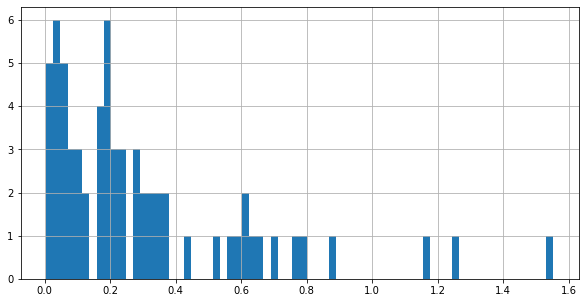

In [91]:
test['diff'].hist(bins=70, figsize=[10,5], grid=True)

In [92]:
pd.unique(test.genre[test['diff']>0.2])

array(['インテリア・寝具・収納', 'インナー・下着・ナイトウェア', 'キッズ・ベビー・マタニティ', 'ジュエリー・アクセサリー',
       'スイーツ・お菓子', 'バッグ・小物・ブランド雑貨', 'メンズファッション', '医薬品・コンタクト・介護', '日本酒・焼酎',
       '腕時計', '車・バイク', '靴', '食品', 'カタログギフト・チケット', 'スポーツ・アウトドア',
       'スマートフォン・タブレット', 'ダイエット・健康', 'パソコン・周辺機器', 'ビール・洋酒', 'レディースファッション',
       '家電', '美容・コスメ・香水'], dtype=object)

In [94]:
test[test['diff']>0.2].sort_values('diff', ascending=False)

,genre,diff
18,メンズファッション,1.553042
20,医薬品・コンタクト・介護,1.258667
4,インナー・下着・ナイトウェア,1.162941
6,キッズ・ベビー・マタニティ,0.877565
18,メンズファッション,0.785713
32,食品,0.773569
8,ジュエリー・アクセサリー,0.698456
32,食品,0.656106
9,スイーツ・お菓子,0.628774
20,医薬品・コンタクト・介護,0.623033
